### Import Model Architectures
Custom Torch Models need to be instantiated for evaluation. The model_architectures.py file contains the model architectures so we can abstract it and focus only on the evaluations.

In [1]:
from model_architectures import *
import model_architectures
from data_curator import *
from attacks import * 
import csv
# Print available classes to verify our model architectures were imported
print(dir(model_architectures))

flags = ['jsma','images']

Using device: cuda
Using device: cuda
['BasicBlock', 'DataLoader', 'F', 'Load', 'ResNetCIFAR', 'ResNetMNIST', 'ResnetSVHN', 'TensorDataset', 'Tester', 'Visualizer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'cifar_directory', 'conv3x3', 'current_directory', 'device', 'mnist_directory', 'nn', 'np', 'os', 'pd', 'pickle', 'plt', 'scipy', 'svhn_directory', 'torch']


### Loading the Model Weights
Using our model artifacts we load the weights back into the model so we have our pre-trained models to test our perturbations against.

In [2]:
mnist_resnet_model = ResNetMNIST(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=True).to(device)
cifar_resnet_model = ResNetCIFAR(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)
svhn_resnet_model = ResnetSVHN(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)

#add map_location=torch.device('cpu') if running locally and ur not sai lol
device = 'cuda'
# mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth", map_location=torch.device(device)))
# cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth", map_location=torch.device(device)))
# svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth",map_location=torch.device(device)))
mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth"))
cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth"))
svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth"))

<All keys matched successfully>

In [3]:
mnist_resnet_model.eval()
cifar_resnet_model.eval()
svhn_resnet_model.eval()

ResnetSVHN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [4]:
# Loading Data
loader = Load()
mnist_train_images, mnist_train_labels = loader.load_mnist_train_images()
cifar10_train_images, cifar10_train_labels = loader.load_cifar10_train_images()
svhn_train_images, svhn_train_labels = loader.load_svhn_train_images()

In [5]:
# train_loader_mnist = loader.convert_mnist_numpy_to_tensor(mnist_train_images, mnist_train_labels)
# train_loader_cifar10 = loader.convert_cifar10_numpy_to_tensor(cifar10_train_images, cifar10_train_labels)
# train_loader_svhn = loader.convert_svhn_numpy_to_tensor(svhn_train_images, svhn_train_labels)

batch_size = 10 * 256

train_loader_mnist = loader.convert_mnist_numpy_to_tensor(mnist_train_images[:batch_size], mnist_train_labels[:batch_size])
train_loader_cifar10 = loader.convert_cifar10_numpy_to_tensor(cifar10_train_images[:batch_size], cifar10_train_labels[:batch_size])
train_loader_svhn = loader.convert_svhn_numpy_to_tensor(svhn_train_images[:batch_size], svhn_train_labels[:batch_size])



### Curating Data
We repurpose our test functions for each attack to only output adversarial examples and the total accuracy from the attack without any hanging print statements. We then run them on the entire dataset, as opposed to a sample of 256, and then store these as CSV files. 

In [6]:
curator = Curator()

In [7]:
if 'fgsm' in flags:
    fgsm_mnist_accuracy, fgsm_mnist_examples = curator.curate_fgsm(mnist_resnet_model, train_loader_mnist, 0.05)
    fgsm_cifar10_accuracy, fgsm_cifar10_examples = curator.curate_fgsm(cifar_resnet_model, train_loader_cifar10, 0.025)
    fgsm_svhn_accuracy, fgsm_svhn_examples = curator.curate_fgsm(svhn_resnet_model, train_loader_svhn, 0.025)

In [8]:
def reshape_image(flat_image, color = False):
    if color:
        # print(flat_image.shape)
        image_size = 32

        # Split the array into three parts
        split_size = flat_image.shape[0] // 3
        red_channel = flat_image[:split_size]
        green_channel = flat_image[split_size:2*split_size]
        blue_channel = flat_image[2*split_size:]
        # print(f"Red Shape: {red_channel.shape}")
        # print(f"Green Shape: {green_channel.shape}")
        # print(f"Blue Shape: {blue_channel.shape}")

        # Stack the three parts horizontally
        stacked_channels = np.dstack([red_channel, green_channel, blue_channel])
        # print(stacked_channels.shape)

        # Reshape the stacked array into a 3D array
        flat_image = stacked_channels.reshape( image_size, image_size, 3)

        return flat_image
    return np.array(flat_image).reshape(28, 28)

(7946, 785)
(47416, 3073)
(32, 32, 3)
(54354, 3073)
(32, 32, 3)


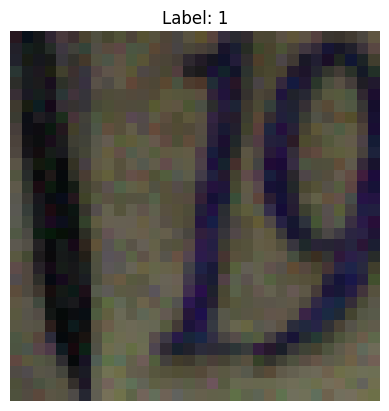

In [9]:

if 'fgsm' in flags:
    print(fgsm_mnist_accuracy)
    print(len(fgsm_mnist_examples))
    print(len(fgsm_mnist_examples[0]))
    print(fgsm_mnist_examples[0][2].shape)

    curator.store_data('augmented_data/fgsm_mnist_augmented_data.csv', fgsm_mnist_examples)

    print(fgsm_cifar10_accuracy)
    print(len(fgsm_cifar10_examples))
    print(len(fgsm_cifar10_examples[0]))
    print(fgsm_cifar10_examples[0][2].shape)

    curator.store_data('augmented_data/fgsm_cifar10_augmented_data.csv', fgsm_cifar10_examples, color = True)

    print(fgsm_svhn_accuracy)
    print(len(fgsm_svhn_examples))
    print(len(fgsm_svhn_examples[0]))
    print(fgsm_svhn_examples[0][2].shape)

    curator.store_data('augmented_data/fgsm_svhn_augmented_data.csv', fgsm_svhn_examples, color = True)

if 'images' in flags:
    # Load the images from the csv, convert them to h5, and then use the h5 file. 
    if 'fgsm' in flags:
        images = pd.read_csv("augmented_data/fgsm_mnist_augmented_data.csv")
        images.to_hdf("augmented_data/fgsm_mnist_augmented_data.h5", key='data', mode='w')
    images = pd.read_hdf('augmented_data/fgsm_mnist_augmented_data.h5')
    print(images.shape)
    labels = images.iloc[:, 0]  
    images = images.iloc[:, 1:]  

    # Selecting the first image and its label
    first_image = images.iloc[0]
    first_label = int(labels.iloc[0])

    # Reshape the image
    reshaped_image1 = reshape_image(first_image)

    if 'fgsm' in flags:
        images = pd.read_csv("augmented_data/fgsm_cifar10_augmented_data.csv")
        images.to_hdf("augmented_data/fgsm_cifar10_augmented_data.h5", key='data', mode='w')
    images = pd.read_hdf('augmented_data/fgsm_cifar10_augmented_data.h5')
    print(images.shape)
    labels = images.iloc[:, 0] 
    images = images.iloc[:, 1:]

    # Selecting the first image and its label
    first_image = images.iloc[0]
    first_label = int(labels.iloc[0])

    # Reshape the image
    reshaped_image2 = reshape_image(np.array(first_image), color = True)
    print(reshaped_image2.shape)



    if 'fgsm' in flags:
        images = pd.read_csv("augmented_data/fgsm_svhn_augmented_data.csv")
        images.to_hdf("augmented_data/fgsm_svhn_augmented_data.h5", key='data', mode='w')
    images = pd.read_hdf('augmented_data/fgsm_svhn_augmented_data.h5')
    print(images.shape)
    labels = images.iloc[:, 0] 
    images = images.iloc[:, 1:]

    # Selecting the first image and its label
    first_image = images.iloc[0]
    first_label = int(labels.iloc[0])

    # Reshape the image
    reshaped_image3= reshape_image(np.array(first_image), color = True)
    print(reshaped_image3.shape)
    # Display the image with its label
    plt.imshow(reshaped_image3)
    plt.title(f"Label: {first_label}")
    plt.axis('off')
    plt.show()

In [10]:
if 'pgd' in flags:
    pgd_mnist_accuracy, pgd_mnist_examples = curator.curate_pgd(mnist_resnet_model, train_loader_mnist, .25, 0.1 )
    pgd_cifar10_accuracy, pgd_cifar10_examples = curator.curate_pgd(cifar_resnet_model, train_loader_cifar10, .25, 0.00625)
    pgd_svhn_accuracy, pgd_svhn_examples = curator.curate_pgd(svhn_resnet_model, train_loader_svhn, .25, 0.00625)

(2386, 785)
(2356, 3073)
(32, 32, 3)
(2056, 3073)
(32, 32, 3)


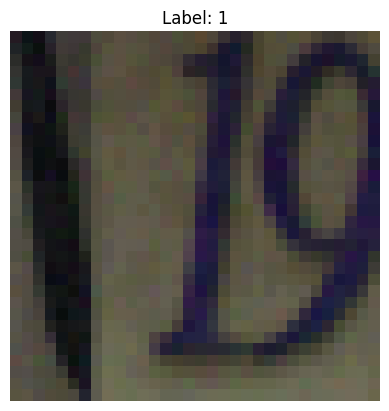

In [11]:

if 'pgd' in flags:
    print(pgd_mnist_accuracy)
    print(len(pgd_mnist_examples))
    print(len(pgd_mnist_examples[0]))
    print(pgd_mnist_examples[0][2].shape)

    curator.store_data('augmented_data/pgd_mnist_augmented_data.csv', pgd_mnist_examples)

    print(pgd_cifar10_accuracy)
    print(len(pgd_cifar10_examples))
    print(len(pgd_cifar10_examples[0]))
    print(pgd_cifar10_examples[0][2].shape)

    curator.store_data('augmented_data/pgd_cifar10_augmented_data.csv', pgd_cifar10_examples, color = True)

    print(pgd_svhn_accuracy)
    print(len(pgd_svhn_examples))
    print(len(pgd_svhn_examples[0]))
    print(pgd_svhn_examples[0][2].shape)

    curator.store_data('augmented_data/pgd_svhn_augmented_data.csv', pgd_svhn_examples, color = True)

if 'images' in flags:
    # Load the images from the csv, convert them to h5, and then use the h5 file. 
    if 'pgd' in flags:
        images = pd.read_csv("augmented_data/pgd_mnist_augmented_data.csv")
        images.to_hdf("augmented_data/pgd_mnist_augmented_data.h5", key='data', mode='w')
    images = pd.read_hdf('augmented_data/pgd_mnist_augmented_data.h5')
    print(images.shape)
    labels = images.iloc[:, 0]  
    images = images.iloc[:, 1:]  

    # Selecting the first image and its label
    first_image = images.iloc[0]
    first_label = int(labels.iloc[0])

    # Reshape the image
    reshaped_image1 = reshape_image(first_image)

    if 'pgd' in flags:
        images = pd.read_csv("augmented_data/pgd_cifar10_augmented_data.csv")
        images.to_hdf("augmented_data/pgd_cifar10_augmented_data.h5", key='data', mode='w')
    images = pd.read_hdf('augmented_data/pgd_cifar10_augmented_data.h5')
    print(images.shape)
    labels = images.iloc[:, 0] 
    images = images.iloc[:, 1:]

    # Selecting the first image and its label
    first_image = images.iloc[0]
    first_label = int(labels.iloc[0])

    # Reshape the image
    reshaped_image2 = reshape_image(np.array(first_image), color = True)
    print(reshaped_image2.shape)



    if 'pgd' in flags:
        images = pd.read_csv("augmented_data/pgd_svhn_augmented_data.csv")
        images.to_hdf("augmented_data/pgd_svhn_augmented_data.h5", key='data', mode='w')
    images = pd.read_hdf('augmented_data/pgd_svhn_augmented_data.h5')
    print(images.shape)
    labels = images.iloc[:, 0] 
    images = images.iloc[:, 1:]

    # Selecting the first image and its label
    first_image = images.iloc[0]
    first_label = int(labels.iloc[0])

    # Reshape the image
    reshaped_image3= reshape_image(np.array(first_image), color = True)
    print(reshaped_image3.shape)
    # Display the image with its label
    plt.imshow(reshaped_image3)
    plt.title(f"Label: {first_label}")
    plt.axis('off')
    plt.show()

In [12]:
if 'deepfool' in flags:
    deepfool_mnist_accuracy, deepfool_mnist_examples = curator.curate_deepfool(mnist_resnet_model, train_loader_mnist)
    deepfool_cifar10_accuracy, deepfool_cifar10_examples = curator.curate_deepfool(cifar_resnet_model, train_loader_cifar10)
    deepfool_svhn_accuracy, deepfool_svhn_examples = curator.curate_deepfool(svhn_resnet_model, train_loader_svhn)

(2560, 785)


(2560, 3073)
(32, 32, 3)
(2560, 3073)
(32, 32, 3)


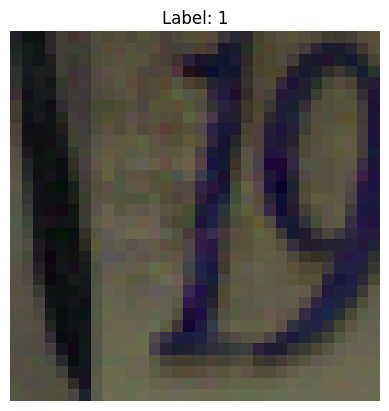

In [13]:

if 'deepfool' in flags:
    print(deepfool_mnist_accuracy)
    print(len(deepfool_mnist_examples))
    print(len(deepfool_mnist_examples[0]))
    print(deepfool_mnist_examples[0][2].shape)

    curator.store_data('augmented_data/deepfool_mnist_augmented_data.csv', deepfool_mnist_examples)

    print(deepfool_cifar10_accuracy)
    print(len(deepfool_cifar10_examples))
    print(len(deepfool_cifar10_examples[0]))
    print(deepfool_cifar10_examples[0][2].shape)

    curator.store_data('augmented_data/deepfool_cifar10_augmented_data.csv', deepfool_cifar10_examples, color = True)

    print(deepfool_svhn_accuracy)
    print(len(deepfool_svhn_examples))
    print(len(deepfool_svhn_examples[0]))
    print(deepfool_svhn_examples[0][2].shape)

    curator.store_data('augmented_data/deepfool_svhn_augmented_data.csv', deepfool_svhn_examples, color = True)

if 'images' in flags:
    # Load the images from the csv, convert them to h5, and then use the h5 file. 
    if 'deepfool' in flags:
        images = pd.read_csv("augmented_data/deepfool_mnist_augmented_data.csv")
        images.to_hdf("augmented_data/deepfool_mnist_augmented_data.h5", key='data', mode='w')
    images = pd.read_hdf('augmented_data/deepfool_mnist_augmented_data.h5')
    print(images.shape)
    labels = images.iloc[:, 0]  
    images = images.iloc[:, 1:]  

    # Selecting the first image and its label
    first_image = images.iloc[0]
    first_label = int(labels.iloc[0])

    # Reshape the image
    reshaped_image1 = reshape_image(first_image)

    if 'deepfool' in flags:
        images = pd.read_csv("augmented_data/deepfool_cifar10_augmented_data.csv")
        images.to_hdf("augmented_data/deepfool_cifar10_augmented_data.h5", key='data', mode='w')
    images = pd.read_hdf('augmented_data/deepfool_cifar10_augmented_data.h5')
    print(images.shape)
    labels = images.iloc[:, 0] 
    images = images.iloc[:, 1:]

    # Selecting the first image and its label
    first_image = images.iloc[0]
    first_label = int(labels.iloc[0])

    # Reshape the image
    reshaped_image2 = reshape_image(np.array(first_image), color = True)
    print(reshaped_image2.shape)



    if 'deepfool' in flags:
        images = pd.read_csv("augmented_data/deepfool_svhn_augmented_data.csv")
        images.to_hdf("augmented_data/deepfool_svhn_augmented_data.h5", key='data', mode='w')
    images = pd.read_hdf('augmented_data/deepfool_svhn_augmented_data.h5')
    print(images.shape)
    labels = images.iloc[:, 0] 
    images = images.iloc[:, 1:]

    # Selecting the first image and its label
    first_image = images.iloc[0]
    first_label = int(labels.iloc[0])

    # Reshape the image
    reshaped_image3= reshape_image(np.array(first_image), color = True)
    print(reshaped_image3.shape)
    # Display the image with its label
    plt.imshow(reshaped_image3)
    plt.title(f"Label: {first_label}")
    plt.axis('off')
    plt.show()

In [14]:
if 'jsma' in flags:
    jsma_mnist_accuracy, jsma_mnist_examples = curator.curate_jsma(mnist_resnet_model, train_loader_mnist, theta = 0.025)
    jsma_cifar10_accuracy, jsma_cifar10_examples = curator.curate_jsma(cifar_resnet_model, train_loader_cifar10, theta = 0.000625)
    jsma_svhn_accuracy, jsma_svhn_examples = curator.curate_jsma(svhn_resnet_model, train_loader_svhn, theta = 0.0025)

C:\Users\Sai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Batch 1 Completed. # of Adversarial Examples: 255
Batch 2 Completed. # of Adversarial Examples: 511
Batch 3 Completed. # of Adversarial Examples: 766
Batch 4 Completed. # of Adversarial Examples: 1022
Batch 5 Completed. # of Adversarial Examples: 1278
Batch 6 Completed. # of Adversarial Examples: 1534
Batch 7 Completed. # of Adversarial Examples: 1790
Batch 8 Completed. # of Adversarial Examples: 2046
Batch 9 Completed. # of Adversarial Examples: 2301
Batch 10 Completed. # of Adversarial Examples: 2555


ValueError: too many values to unpack (expected 2)

In [ ]:

if 'jsma' in flags:
    print(jsma_mnist_accuracy)
    print(len(jsma_mnist_examples))
    print(len(jsma_mnist_examples[0]))
    print(jsma_mnist_examples[0][2].shape)

    curator.store_data('augmented_data/jsma_mnist_augmented_data.csv', jsma_mnist_examples)

    print(jsma_cifar10_accuracy)
    print(len(jsma_cifar10_examples))
    print(len(jsma_cifar10_examples[0]))
    print(jsma_cifar10_examples[0][2].shape)

    curator.store_data('augmented_data/jsma_cifar10_augmented_data.csv', jsma_cifar10_examples, color = True)

    print(jsma_svhn_accuracy)
    print(len(jsma_svhn_examples))
    print(len(jsma_svhn_examples[0]))
    print(jsma_svhn_examples[0][2].shape)

    curator.store_data('augmented_data/jsma_svhn_augmented_data.csv', jsma_svhn_examples, color = True)

if 'images' in flags:
    # Load the images from the csv, convert them to h5, and then use the h5 file. 
    if 'jsma' in flags:
        images = pd.read_csv("augmented_data/jsma_mnist_augmented_data.csv")
        images.to_hdf("augmented_data/jsma_mnist_augmented_data.h5", key='data', mode='w')
    images = pd.read_hdf('augmented_data/jsma_mnist_augmented_data.h5')
    print(images.shape)
    labels = images.iloc[:, 0]  
    images = images.iloc[:, 1:]  

    # Selecting the first image and its label
    first_image = images.iloc[0]
    first_label = int(labels.iloc[0])

    # Reshape the image
    reshaped_image1 = reshape_image(first_image)

    if 'jsma' in flags:
        images = pd.read_csv("augmented_data/jsma_cifar10_augmented_data.csv")
        images.to_hdf("augmented_data/jsma_cifar10_augmented_data.h5", key='data', mode='w')
    images = pd.read_hdf('augmented_data/jsma_cifar10_augmented_data.h5')
    print(images.shape)
    labels = images.iloc[:, 0] 
    images = images.iloc[:, 1:]

    # Selecting the first image and its label
    first_image = images.iloc[0]
    first_label = int(labels.iloc[0])

    # Reshape the image
    reshaped_image2 = reshape_image(np.array(first_image), color = True)
    print(reshaped_image2.shape)



    if 'jsma' in flags:
        images = pd.read_csv("augmented_data/jsma_svhn_augmented_data.csv")
        images.to_hdf("augmented_data/jsma_svhn_augmented_data.h5", key='data', mode='w')
    images = pd.read_hdf('augmented_data/jsma_svhn_augmented_data.h5')
    print(images.shape)
    labels = images.iloc[:, 0] 
    images = images.iloc[:, 1:]

    # Selecting the first image and its label
    first_image = images.iloc[0]
    first_label = int(labels.iloc[0])

    # Reshape the image
    reshaped_image3= reshape_image(np.array(first_image), color = True)
    print(reshaped_image3.shape)
    # Display the image with its label
    plt.imshow(reshaped_image3)
    plt.title(f"Label: {first_label}")
    plt.axis('off')
    plt.show()

0.0046875
2548
3
(28, 28)
0.008203125
2539
3
(3, 32, 32)
0.008203125
2539
3
(3, 32, 32)
(2548, 785)


ValueError: invalid literal for int() with base 10: "tensor([5], device='cuda:0')"